This code takes the mosaicked carbon stock outputs and reprojects them onto an equal area grid so that we can take convert carbon stock density into total carbon stocks

In [1]:
# import packages
from rasterio.warp import Resampling
import geopandas as gpd
import numpy as np
import rioxarray
import xarray
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Point
import pyproj
from geopy.distance import geodesic

### First explore potential distortion surrounding study area, based on a LAEA projection centered at the center of the Y2Y region

In [2]:
# load y2y boundary
y2y = './study_area/Y2Y_RegionBoundary_Final2013/Y2Y_RegionBoundary.shp'

In [3]:
# find center of y2y region
# Load the shapefile
gdf = gpd.read_file(y2y)

# Reproject to WGS84 if necessary
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Get the bounding box (minx, miny, maxx, maxy)
minx, miny, maxx, maxy = gdf.total_bounds

# Calculate the center (midpoint of the bounding box)
center_lon = (minx + maxx) / 2
center_lat = (miny + maxy) / 2

print(f"Latitude: {center_lat}, Longitude: {center_lon}")

Latitude: 54.53624536240069, Longitude: -124.66760996293321


/var/folders/61/b_g16g9n7h1864j7mrkvshbw0000gn/T/ipykernel_12222/1147800339.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


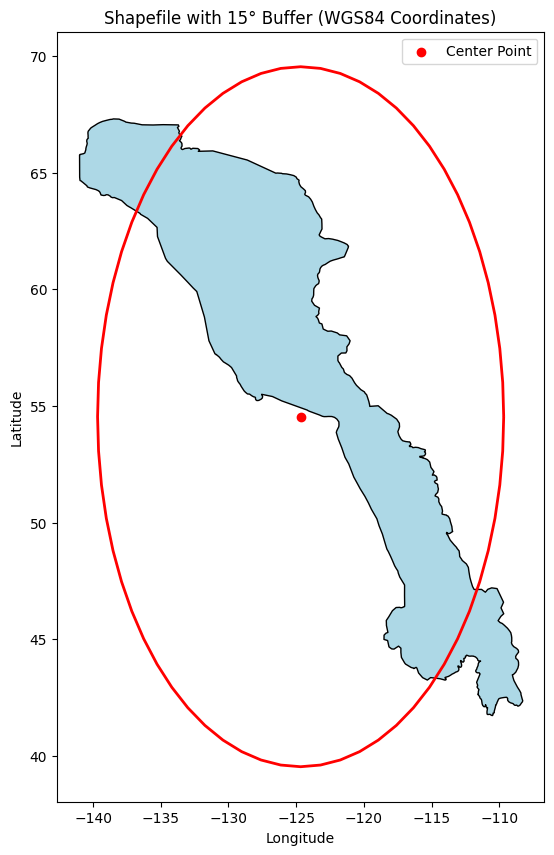

In [4]:
# LAEA projection is distorted less than 2% within 15 degrees from the center
# map Y2Y with 15 degree buffer
# Define the center point in WGS84 (latitude, longitude)
center_point = Point(center_lon, center_lat)

# Create a buffer of 15 degrees around the center
buffer_15deg = center_point.buffer(15)  # Buffer in degrees

# Convert the buffer into a GeoSeries for plotting
buffer_gs = gpd.GeoSeries([buffer_15deg], crs="EPSG:4326")

# Reproject the shapefile to WGS84, if not already
if gdf.crs != "EPSG:4326":
    gdf_wgs84 = gdf.to_crs("EPSG:4326")
else:
    gdf_wgs84 = gdf

# Plot the shapefile, center, and buffer
fig, ax = plt.subplots(figsize=(10, 10))
gdf_wgs84.plot(ax=ax, color="lightblue", edgecolor="black", label="Shapefile")
buffer_gs.plot(ax=ax, color="none", edgecolor="red", linewidth=2, label="15° Buffer")
ax.scatter(center_lon, center_lat, color="red", marker="o", label="Center Point", zorder=5)

# Add labels and legend
ax.set_title("Shapefile with 15° Buffer (WGS84 Coordinates)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

# Show the plot
plt.show()

Distortion is minimal, a bit more at the far reaches of the region but acceptable for our application. Equal area is again a bigger concern.

### Reproject final carbon stock layers into the desired equal area project

In [5]:
# define print raster function to help compare reprojections
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
        f"NoDataValue: {raster.rio.nodata}\n"
        f"NoDataOriginalValues: {raster.rio.encoded_nodata}\n"
    )

In [6]:
# define laea projection centered on Y2Y
laea = '+proj=laea +lat_0=55 +lon_0=-125 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'

In [7]:
# load file paths for carbon rasters
agb_path = './carbon_stock_data/output_layers/agb_c_spawn_t_ha.tif'
bgb_path = './carbon_stock_data/output_layers/bgb_c_spawn_t_ha.tif'
soc_path = './carbon_stock_data/output_layers/soc_0_1m_t_ha.tif'


In [8]:
# load file path for landcover raster
lc_path = './land_cover/landcover-2020-classification-y2y.tif'

In [9]:
# load data arrays
agb = xarray.open_dataarray(agb_path)
bgb = xarray.open_dataarray(bgb_path)
soc = xarray.open_dataarray(soc_path)
lc = xarray.open_dataarray(lc_path)

In [10]:
# print rasters
print_raster(agb)
print_raster(bgb)
print_raster(soc)
print_raster(lc)

shape: (9206, 11785)
resolution: (0.0027777777777779986, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 871243200.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (9206, 11785)
resolution: (0.0027777777777779986, -0.002777777777778)
bounds: (-141.03611111111087, 41.750000000000064, -108.29999999999715, 67.32222222222433)
sum: 359978112.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (11386, 14570)
resolution: (0.0022457898480768247, -0.0022457903991559697)
bounds: (-141.01985, 41.75143371197468, -108.29869191352066, 67.32200319676454)
sum: 8916239360.0
CRS: EPSG:4326
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (107107, 39197)
resolution: (30.0, -30.0)
bounds: (-1858020.0, -304960.0, -682110.0, 2908250.0)
sum: 9645177856.0
CRS: PROJCS["WGS_1984_Lambert_Azimuthal_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG",

In [11]:
# # plot soc to check if nodata values are correct
# fig, ax = plt.subplots(ncols=1, figsize=(12,4))
# soc.plot(ax=ax)
# plt.draw()

In [12]:
# reproject agb and bgb layers
# use average resampling since these are density values
agb_laea = agb.rio.reproject(dst_crs = laea, resolution = 250, resampling = Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)
bgb_laea = bgb.rio.reproject_match(agb_laea, resampling = Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)
print_raster(agb_laea)
print_raster(bgb_laea)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 770079040.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 309278432.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]

In [13]:
# reproject soc layer
soc_laea = soc.rio.reproject_match(agb_laea, resampling = Resampling.average, NODATA_VALUES_PCT_THRESHOLD=50)
print_raster(soc_laea)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 4683148800.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: nan
NoDataOriginalValues: -9999.0



In [14]:
# reproject lc layer
# use mode resampling for landcover
lc_laea = lc.rio.reproject_match(agb_laea, resampling = Resampling.mode, NODATA_VALUES_PCT_THRESHOLD=50)
print_raster(lc_laea)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 133465320.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: nan
NoDataOriginalValues: 0.0



In [15]:
# use assign_cords to make sure an exact match (issue with floating precision)
bgb_laea = bgb_laea.assign_coords({
    "x": agb_laea.x,
    "y": agb_laea.y,
})

soc_laea = soc_laea.assign_coords({
    "x": agb_laea.x,
    "y": agb_laea.y,
})

lc_laea = lc_laea.assign_coords({
    "x": agb_laea.x,
    "y": agb_laea.y,
})

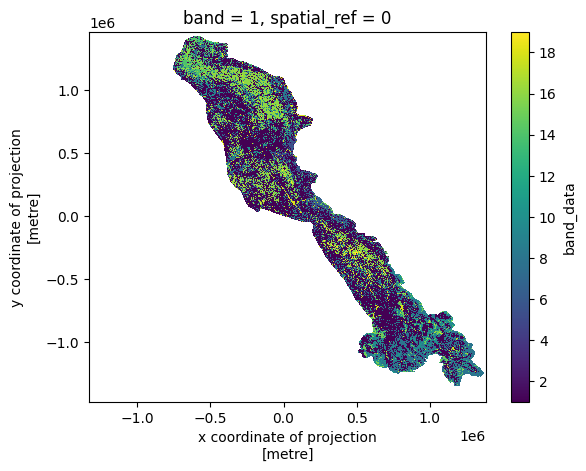

In [16]:
# plot LC layer
lc_laea.plot()

In [17]:
# mask SOC values corresponding to water and snow/ice landcover
ignore_classes = [18, 19] # 18 = water, 19 = snow/ice

# mask water and snow/ice
for val in ignore_classes:
    agb_laea = agb_laea.where(lc_laea!=val, other=np.nan)
    bgb_laea = bgb_laea.where(lc_laea!=val, other=np.nan)
    soc_laea = soc_laea.where(lc_laea!=val, other=np.nan)

In [18]:
# # export rasters
# agb_laea.rio.to_raster(agb_path.replace('.tif', '_laea.tif'))
# bgb_laea.rio.to_raster(bgb_path.replace('.tif', '_laea.tif'))
# soc_laea.rio.to_raster(soc_path.replace('.tif', '_laea.tif'))

In [19]:
# multiply by area to get a total t Carbon per cell
agb_laea_t = agb_laea * ((250*250)/(100*100))
bgb_laea_t = bgb_laea * ((250*250)/(100*100))
soc_laea_t = soc_laea * ((250*250)/(100*100))

In [20]:
# write no data values into metadata
agb_laea_t.rio.write_nodata(-9999, encoded=True, inplace=True)
bgb_laea_t.rio.write_nodata(-9999, encoded=True, inplace=True)
soc_laea_t.rio.write_nodata(-9999, encoded=True, inplace=True)
print_raster(agb_laea_t)
print_raster(bgb_laea_t)
print_raster(soc_laea_t)

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 4796549120.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",55],PARAMETER["longitude_of_center",-125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
NoDataValue: nan
NoDataOriginalValues: -9999.0

shape: (11718, 10862)
resolution: (250.0, -250.0)
bounds: (-1330621.3668208027, -1470244.0239490846, 1384878.6331791973, 1459255.9760509154)
sum: 1924812032.0
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030

In [21]:
# export rasters
agb_laea_t.rio.to_raster(agb_path.replace('t_ha.tif', 't_laea.tif'))
bgb_laea_t.rio.to_raster(bgb_path.replace('t_ha.tif', 't_laea.tif'))
soc_laea_t.rio.to_raster(soc_path.replace('t_ha.tif', 't_laea.tif'))
lc_laea.rio.to_raster(lc_path.replace('.tif', '_laea.tif'))